In [1]:
import osmnx as ox
import pandas as pd
import requests

## Descarga de los grafos

In [2]:
def get_walking_network(place_name: str):
    """
    Get the walking network for a specified place using OSMnx.

    Parameters:
        place_name (str): The name of the place to get the walking network for.

    Returns:
        graph: A directed graph representing the walking network.
    """
    graph = ox.graph_from_place(place_name, network_type="walk")

    return graph


def get_cycling_network(place_name: str):
    """
    Get the cycling network for a specified place using OSMnx.

    Parameters:
        place_name (str): The name of the place to get the cycling network for.

    Returns:
        graph: A directed graph representing the cycling network.
    """
    graph = ox.graph_from_place(
        place_name,
        network_type="bike",
        custom_filter='["highway"~"cycleway|path|unclassified|track"]',
    )

    return graph


walk_graph = get_walking_network("Valencia, Spain")
cycle_graph = get_cycling_network("Valencia, Spain")

# Save the graphs to files
ox.save_graphml(walk_graph, filepath="../data/valencia_walking_network.graphml")
ox.save_graphml(cycle_graph, filepath="../data/valencia_cycling_network.graphml")


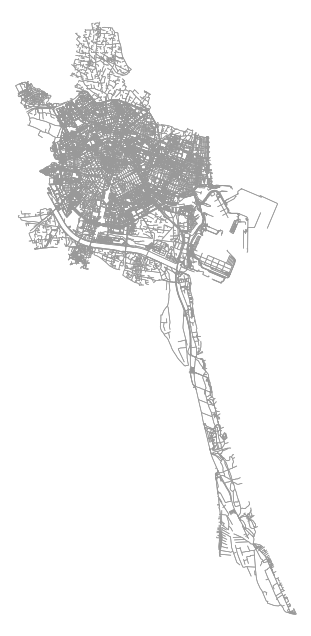

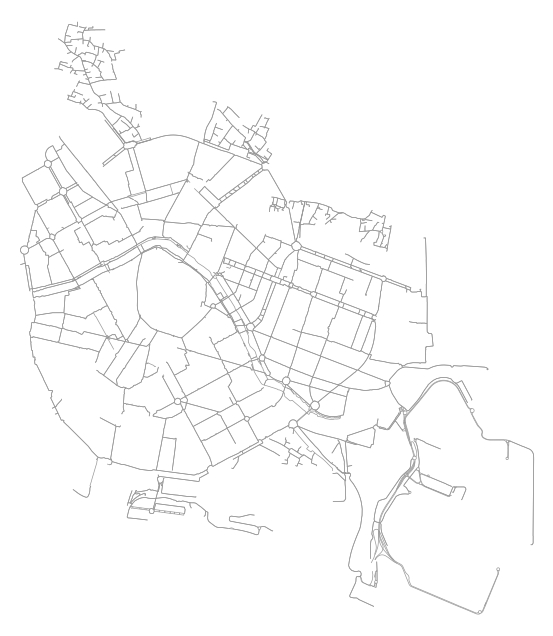

Text(0.5, 1.0, 'Cycling Network in Valencia, Spain')

In [3]:
# Load the saved graphs from files
walk_graph = ox.load_graphml("../data/valencia_walking_network.graphml")
cycle_graph = ox.load_graphml("../data/valencia_cycling_network.graphml")

# Pintar ambos grafos sobre un mapa, para ver que se corresponden bien las calles
fig_walk, ax_walk = ox.plot_graph(
    walk_graph, node_size=0, edge_linewidth=0.5, bgcolor="white"
)
ax_walk.set_title("Walking Network in Valencia, Spain")
fig_cycle, ax_cycle = ox.plot_graph(
    cycle_graph, node_size=0, edge_linewidth=0.5, bgcolor="white"
)
ax_cycle.set_title("Cycling Network in Valencia, Spain")

In [4]:
# convertir las aritas a GeoDataFrames para poder guardarlas como shapefiles

walk_edges = ox.graph_to_gdfs(walk_graph, nodes=False, edges=True)
cycle_edges = ox.graph_to_gdfs(cycle_graph, nodes=False, edges=True)

cycle_edges

osmid  \
u          v           key                                                      
2271477761 109552296   0                                            217845192   
297664582  1555329321  0                               [27130664, 1313829854]   
           297664633   0                                            772916988   
297664618  297664642   0                                             27130677   
           1555329321  0                             [1364968436, 1253420365]   
...                                                                       ...   
476446471  110553109   0    [89212769, 901192930, 901192931, 901193831, 90...   
2271477727 11848234345 0                                             84202772   
           109552531   0                                             84202772   
           11847966706 0                                           1276183791   
2271477738 2271478339  0                                            217845153   

                                 highway  oneway reversed       length  \
u          v           key                                               
2271477761 109552296   0           track   False     True   103.827452   
297664582  1555329321  0        cycleway   False     True   129.723976   
           297664633   0        cycleway    True    False   185.450011   
297664618  297664642   0        cycleway   False    False   108.486532   
           1555329321  0        cycleway    True    False   514.977423   
...                                  ...     ...      ...          ...   
476446471  110553109   0        cycleway   False     True  2083.235493   
2271477727 11848234345 0    unclassified   False    False   112.915575   
           109552531   0    unclassified   False     True    63.128152   
           11847966706 0           track   False    False    77.002155   
2271477738 2271478339  0            path   False    False   169.318819   

                                                                     geometry  \
u          v           key                                                      
2271477761 109552296   0    LINESTRING (-0.33683 39.48532, -0.3369 39.4853...   
297664582  1555329321  0    LINESTRING (-0.36305 39.46773, -0.36303 39.467...   
           297664633   0    LINESTRING (-0.36305 39.46773, -0.3625 39.4668...   
297664618  297664642   0    LINESTRING (-0.3595 39.46404, -0.35953 39.4640...   
           1555329321  0    LINESTRING (-0.3595 39.46404, -0.35952 39.4641...   
...                                                                       ...   
476446471  110553109   0    LINESTRING (-0.34038 39.4455, -0.34034 39.4454...   
2271477727 11848234345 0    LINESTRING (-0.33341 39.48301, -0.33343 39.482...   
           109552531   0    LINESTRING (-0.33341 39.48301, -0.3334 39.4830...   
           11847966706 0    LINESTRING (-0.33341 39.48301, -0.33334 39.483...   
2271477738 2271478339  0    LINESTRING (-0.33571 39.48562, -0.33617 39.485...   

                           maxspeed name bridge lanes width tunnel junction  \
u          v           key                                                    
2271477761 109552296   0        NaN  NaN    NaN   NaN   NaN    NaN      NaN   
297664582  1555329321  0        NaN  NaN    NaN   NaN   NaN    NaN      NaN   
           297664633   0        NaN  NaN    NaN   NaN   NaN    NaN      NaN   
297664618  297664642   0        NaN  NaN    NaN   NaN   NaN    NaN      NaN   
           1555329321  0        NaN  NaN    NaN   NaN   NaN    NaN      NaN   
...                             ...  ...    ...   ...   ...    ...      ...   
476446471  110553109   0        NaN  NaN    yes   NaN   NaN    NaN      NaN   
2271477727 11848234345 0        NaN  NaN    NaN   NaN   NaN    NaN      NaN   
           109552531   0        NaN  NaN    NaN   NaN   NaN    NaN      NaN   
           11847966706 0        NaN  NaN    NaN   NaN   NaN    NaN      NaN   
2271477738 2271478339  0        NaN  NaN    NaN   NaN

In [5]:
cycle_edges["highway"].value_counts()

highway
cycleway                 1814
unclassified              571
track                     460
path                       86
[path, track]              10
[unclassified, track]      10
[path, cycleway]            8
Name: count, dtype: int64

## Funtes de la ciudad

In [6]:
def get_valencian_open_data(url: str, params: dict = None):
    """
    Fetch open data from the Valencia City Council's open data portal.

    Returns:
        dict: A dictionary containing the fetched data.
    """
    df = pd.DataFrame()
    response = requests.get(url, params=params)

    if response.status_code == 200:
        total_records = response.json().get("total_count")
        print(f"Total records found: {total_records}")

        for start in range(0, total_records, params.get("rows", 10)):
            params["start"] = start
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                records = data.get("results", [])
                df = pd.concat([df, pd.DataFrame(records)], ignore_index=True)
            else:
                raise Exception(
                    f"Failed to fetch data: {response.status_code}\n{response.text}"
                )

        return df
    else:
        raise Exception(
            f"Failed to fetch data: {response.status_code}\n{response.text}"
        )


params = {
    "rows": 100,
}

url = "https://valencia.opendatasoft.com//api/explore/v2.1/catalog/datasets/fonts-daigua-publica-fuentes-de-agua-publica/records"
valencian_data = get_valencian_open_data(url, params)
valencian_data

Total records found: 832


,objectid,calle,codigo,foto,geo_shape,geo_point_2d
0,5,PASEO MARITIMO/HISTORIADOR COLOMA--2ª,1151,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3245649933146064, 'lat': 39.4703178..."
1,9,BULEVAR SUR - BARRACA AUSIAS MARCH 1,1040,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.37167000776736375, 'lat': 39.445251..."
2,11,PLAZA DEL MERCADO,110,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.37922498535436144, 'lat': 39.474571..."
3,17,JARDIN PLAZA DE LA REINA,104,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.37553501058701816, 'lat': 39.474624..."
4,22,CEMENTERIO GENERAL SEC 20-1,C121,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3986200087544989, 'lat': 39.4429817..."
...,...,...,...,...,...,...
827,230,PLATERO SUAREZ /CALLE SAGUNTO,509,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.37407299938987454, 'lat': 39.485198..."
828,267,"AVDA. BLASCO IBAÑEZ, 96",1312,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.35000500025418557, 'lat': 39.474304..."
829,276,PLAZA JOAQUIN MUÑOZ PEIRATS 1,1607,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3951179978157639, 'lat': 39.4869956..."
830,150,PL DOCTOR LORENZO DE LA FLOR,1155,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.33100999912996454, 'lat': 39.469399..."


In [7]:
valencian_data.to_csv("../data/fonts_publiques.csv", index=False)

## Estciones de ValenBisi

In [8]:
url = "https://valencia.opendatasoft.com//api/explore/v2.1/catalog/datasets/valenbisi-disponibilitat-valenbisi-dsiponibilidad/records"
valenbisi_data = get_valencian_open_data(url, params)
valenbisi_data

Total records found: 273


,address,number,open,available,free,total,ticket,updated_at,geo_shape,geo_point_2d,update_jcd
0,General Urrutia - Granada,41,T,9,10,20,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.36477635908979195, 'lat': 39.458912...",2025-06-21T18:01:32+00:00
1,Plaza de Europa,54,T,8,12,20,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3526903171951741, 'lat': 39.4597782...",2025-06-21T18:01:39+00:00
2,Vicent Vidal - Pintor Maella,61,T,10,10,20,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.34783029886743094, 'lat': 39.461293...",2025-06-21T18:06:18+00:00
3,Menorca - Baleares,62,T,9,11,20,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3421522812931475, 'lat': 39.4598112...",2025-06-21T18:04:26+00:00
4,Av Puerto 19 (Telefónica),63,T,5,15,20,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.358414330727018, 'lat': 39.46777930...",2025-06-21T18:06:58+00:00
...,...,...,...,...,...,...,...,...,...,...,...
268,Padre Esteban Pernet - Casa Misericordia,263,T,9,8,18,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.4096445056541294, 'lat': 39.4670433...",2025-06-21T18:04:01+00:00
269,Traginers - Pedrapiquers,260,T,8,12,20,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.4072175039832668, 'lat': 39.4595562...",2025-06-21T18:01:59+00:00
270,Tres Forques - Colonia Española de Mexico,262,T,3,17,20,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.40922550688289966, 'lat': 39.463472...",2025-06-21T18:07:23+00:00
271,Av. del Cid - Marconi,264,T,9,11,20,F,21/06/2025 18:09:25,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.4144325204450301, 'lat': 39.4691603...",2025-06-21T18:03:49+00:00


In [9]:
valenbisi_data["geo_shape"][0]

{'type': 'Feature',
 'geometry': {'coordinates': [-0.36477635908979195, 39.458912276426375],
  'type': 'Point'},
 'properties': {}}

## Prueba de mapa

In [10]:
import folium


def create_map_with_stations(graph, title):
    """
    Create a folium map with the cycling network and Valenbisi stations.

    Parameters:
        graph: The cycling network graph.
        stations_gdf (GeoDataFrame): A GeoDataFrame containing Valenbisi stations.
        title (str): The title of the map.

    Returns:
        folium.Map: A folium map object.
    """
    m = folium.Map(
        location=[39.4699, -0.3763],  # Centered on Valencia
        zoom_start=13,
        tiles="OpenStreetMap",
    )

    # Add the cycling network edges to the map
    for t in graph.edges(data=True):
        ini, fin, info = t
        start = (graph.nodes[ini]["y"], graph.nodes[ini]["x"])
        end = (graph.nodes[fin]["y"], graph.nodes[fin]["x"])
        folium.PolyLine(
            locations=[start, end], color="blue", weight=2, opacity=0.8
        ).add_to(m)

    m.get_root().html.add_child(folium.Element(f"<h3>{title}</h3>"))
    return m


# Create maps with Valenbisi stations
# walk_map = create_map_with_stations(
#     walk_graph, geovalenbisi_walk, "Walking Network with Valenbisi Stations"
# )

cycle_map = create_map_with_stations(
    cycle_graph, "Cycling Network with Valenbisi Stations"
)

cycle_map